In [1]:
#import & load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser

%pylab inline
pylab.rcParams['figure.figsize'] = (16, 9)

df_apps = pd.read_csv('googleplaystore_origin.csv')
df_apps.head()

Populating the interactive namespace from numpy and matplotlib


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [2]:
for col in df_apps.columns:
    print(col, type(df_apps[col][1]))

App <class 'str'>
Category <class 'str'>
Rating <class 'numpy.float64'>
Reviews <class 'str'>
Size <class 'str'>
Installs <class 'str'>
Type <class 'str'>
Price <class 'str'>
Content Rating <class 'str'>
Genres <class 'str'>
Last Updated <class 'str'>
Current Ver <class 'str'>
Android Ver <class 'str'>


In [3]:
#row 10472 doesn't have value for category; its following values are shifted
#shift the row to make it right
df_apps.iloc[10472] = df_apps.iloc[10472].shift(1)
df_apps.loc[10472, 'App'] = df_apps.loc[10472, 'Category']
df_apps.loc[10472, 'Category'] = ''

In [4]:
#data type transformations
def to_int(x):
    if ''.join(str(x).split('.')).isdigit():
        return int(x)
    else:
        print('not digit',x)
        
def size_to_float(x):
    if len(str(x))>0:
        out = 0.0
        if x[-1] in ['M','m']:
            out = float(''.join(x[:-1].split('.'))) * 1000
        elif x[-1] in ['K','k']:
            out = float(''.join(x[:-1].split('.')))
        else:
            out = np.nan
        return out
    else:
        return 0
    
def install_to_int(x):
    if x[-1] == '+':
        return int(''.join(x[:-1].split(',')))
    else:
        return 0
    
def price_to_float(x):
    if x[0] == '$':
        return float(''.join(x[1:].split('.')))
    else:
        return 0.0
    
def str_to_date(x):
    try:
        dt = parser.parse(x)
        return dt
    except:
        print('problem date:', x)
    
df_apps.Reviews = df_apps.Reviews.apply(to_int)
df_apps.Size = df_apps.Size.apply(size_to_float)

#keeping original Installs column
df_apps['installs_int'] = df_apps.Installs.apply(install_to_int)
df_apps.Price = df_apps.Price.apply(price_to_float)
df_apps['Last Updated'] = df_apps['Last Updated'].apply(str_to_date)

In [5]:
#encode Category only
#not encoding type, since price will be 0 if type is free
#not using Genre for now
#compare different methods of encoding, do it later

df_apps.Category.unique()

array(['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
       'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FINANCE',
       'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME',
       'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'GAME', 'FAMILY', 'MEDICAL',
       'SOCIAL', 'SHOPPING', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL',
       'TOOLS', 'PERSONALIZATION', 'PRODUCTIVITY', 'PARENTING', 'WEATHER',
       'VIDEO_PLAYERS', 'NEWS_AND_MAGAZINES', 'MAPS_AND_NAVIGATION', ''], dtype=object)

In [6]:
#what's up with the repititions?
#it appears that data on the same app might have been collected mulitple times
#only keep the record with the largest number of reviews

print(len(df_apps), len(df_apps.App.unique()))
duplications = df_apps.App.value_counts()[df_apps.App.value_counts() > 1]


for app in duplications.keys():
    appearances = df_apps[df_apps.App == app]
    drop_i = appearances.sort_values('Reviews', ascending=False).index[1:]
    df_apps.drop(drop_i, inplace=True)
    
print(len(df_apps), len(df_apps.App.unique()))

10841 9660
9660 9660


In [7]:
#excluding apps with less than 5000 installs
drop_i = df_apps[df_apps.installs_int < 5000].index
df_apps.drop(drop_i, inplace=True)
len(df_apps)

6982

In [8]:
#construct extra columns

#reviews per install
df_apps['reviews_per_install'] = df_apps.Reviews/df_apps.installs_int

#days from last update to 20180831
end_date = datetime.datetime(2018,8,31,0,0,0)
def get_delta(x):
    d = end_date - x
    return d.days
df_apps['updated_delta'] = df_apps['Last Updated'].apply(get_delta)

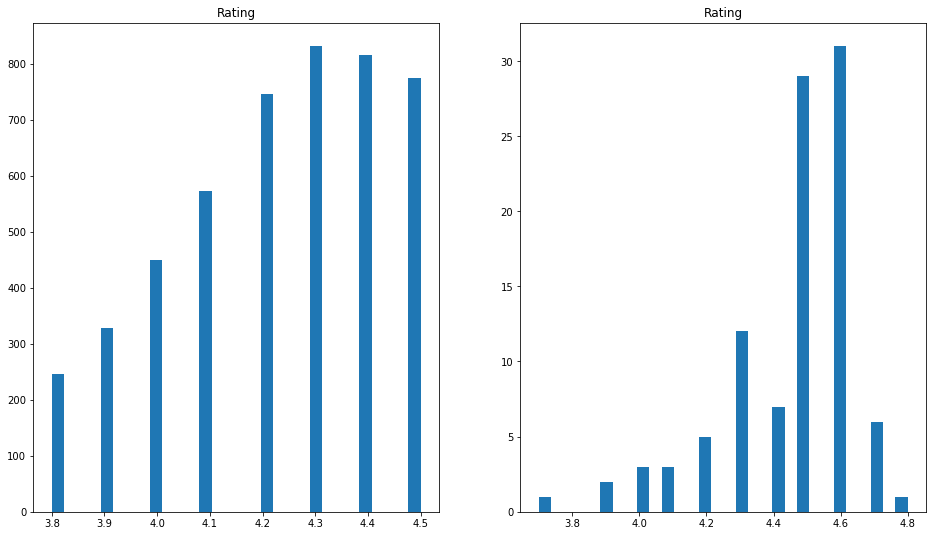

In [85]:
#comparisons of top100 and all

#picking out the best apps
df_apps['rating_installs'] = df_apps.Rating * df_apps.installs_int
top_100 = df_apps.sort_values('rating_installs', ascending=False)[:100]

def comp_hist(col):
    fig = plt.figure()
    f, axarr = plt.subplots(1,2)
    axarr[0].hist(df_apps[col], bins=30)
    axarr[0].set_title(col)
    axarr[1].hist(top_100[col], bins=30)
    axarr[1].set_title(col)
    plt.show()
    
def comp_pie(col):
    fig = plt.figure()
    f, axarr = plt.subplots(1,2)
    axarr[0].pie(top_cate, labels=top_cate.keys(), autopct='%1.1f%%')
    axarr[0].axis('equal')
    axarr[1].pie(top_100[col], bins=30)
    axarr[1].set_title(col)
    
comp_hist('Rating')

In [79]:
#functions to plot distributions & general EDA
#remember to include a boxplot comparison by categories

#plot distributions of ...
def dist_plots(d):
    fig = plt.figure()
    f, axarr = plt.subplots(2,3)

    #df_apps['log_installs'] = df_apps.installs_int.apply(log)
    #install_below_1m = d.installs_int[df_apps.installs_int <= 100000000]
    price_below_400 = d.Price[df_apps.Price <= 400]
    sizes = d.Size.dropna()

    axarr[0][0].hist(d.Rating, bins=10)
    axarr[0][0].set_title('Ratings')
    axarr[0][1].hist(d.installs_int, bins=40)
    axarr[0][1].set_title('Installs')
    axarr[0][2].hist(price_below_400, bins=40)
    axarr[0][2].set_title('Price')
    axarr[1][0].hist(d.reviews_per_install, bins=40)
    axarr[1][0].set_title('Reviews per Install')
    axarr[1][1].hist(d.updated_delta, bins=20)
    axarr[1][1].set_title('Days from Last Update')
    axarr[1][2].hist(sizes, bins=20)
    axarr[1][2].set_title('Size (KB)')


    plt.show()
    
def paid_cate(d):
    fig = plt.figure()
    f, axarr = plt.subplots(1,2)

    #free or paid
    pay_ = d.Type.value_counts()
    axarr[0].pie(pay_, labels=pay_.keys(), autopct='%1.1f%%')
    axarr[0].axis('equal')
    axarr[0].set_title('Free or Paid')

    #categories pie
    top_cate = d.Category.value_counts()[:3]
    axarr[1].pie(top_cate, labels=top_cate.keys(), autopct='%1.1f%%')
    axarr[1].axis('equal')
    axarr[1].set_title('Categories')

    plt.show()
    
def cate_breakdown(d):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    category_counts = d.Category.value_counts()
    xs = list(range(len(category_counts)))
    ax.bar(xs, height=category_counts)
    ax.set_xticks(xs)
    ax.set_xticklabels(category_counts.keys(), rotation=90)
    plt.show()

In [67]:
#picking out the best apps
df_apps['rating_installs'] = df_apps.Rating * df_apps.installs_int
top_100 = df_apps.sort_values('rating_installs', ascending=False)[:100]
top_100

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,installs_int,reviews_per_install,updated_delta,rating_installs
2604,Instagram,SOCIAL,4.5,66577446,NaN,"1,000,000,000+",Free,0.0,Teen,Social,2018-07-31,Varies with device,Varies with device,1000000000,0.066577,31,4.5e+09
2884,Google Photos,PHOTOGRAPHY,4.5,10859051,NaN,"1,000,000,000+",Free,0.0,Everyone,Photography,2018-08-06,Varies with device,Varies with device,1000000000,0.010859,25,4.5e+09
1872,Subway Surfers,GAME,4.5,27725352,76000.0,"1,000,000,000+",Free,0.0,Everyone 10+,Arcade,2018-07-12,1.90.0,4.1 and up,1000000000,0.027725,50,4.5e+09
3234,Google,TOOLS,4.4,8033493,NaN,"1,000,000,000+",Free,0.0,Everyone,Tools,2018-08-03,Varies with device,Varies with device,1000000000,0.008033,28,4.4e+09
336,WhatsApp Messenger,COMMUNICATION,4.4,69119316,NaN,"1,000,000,000+",Free,0.0,Everyone,Communication,2018-08-03,Varies with device,Varies with device,1000000000,0.069119,28,4.4e+09
3523,Google Drive,PRODUCTIVITY,4.4,2731211,NaN,"1,000,000,000+",Free,0.0,Everyone,Productivity,2018-08-06,Varies with device,Varies with device,1000000000,0.002731,25,4.4e+09
3665,YouTube,VIDEO_PLAYERS,4.3,25655305,NaN,"1,000,000,000+",Free,0.0,Teen,Video Players & Editors,2018-08-02,Varies with device,Varies with device,1000000000,0.025655,29,4.3e+09
5856,Google Play Games,FAMILY,4.3,7168735,NaN,"1,000,000,000+",Free,0.0,Teen,Entertainment,2018-07-16,Varies with device,Varies with device,1000000000,0.007169,46,4.3e+09
411,Google Chrome: Fast & Secure,COMMUNICATION,4.3,9643041,NaN,"1,000,000,000+",Free,0.0,Everyone,Communication,2018-08-01,Varies with device,Varies with device,1000000000,0.009643,30,4.3e+09
451,Gmail,COMMUNICATION,4.3,4604483,NaN,"1,000,000,000+",Free,0.0,Everyone,Communication,2018-08-02,Varies with device,Varies with device,1000000000,0.004604,29,4.3e+09


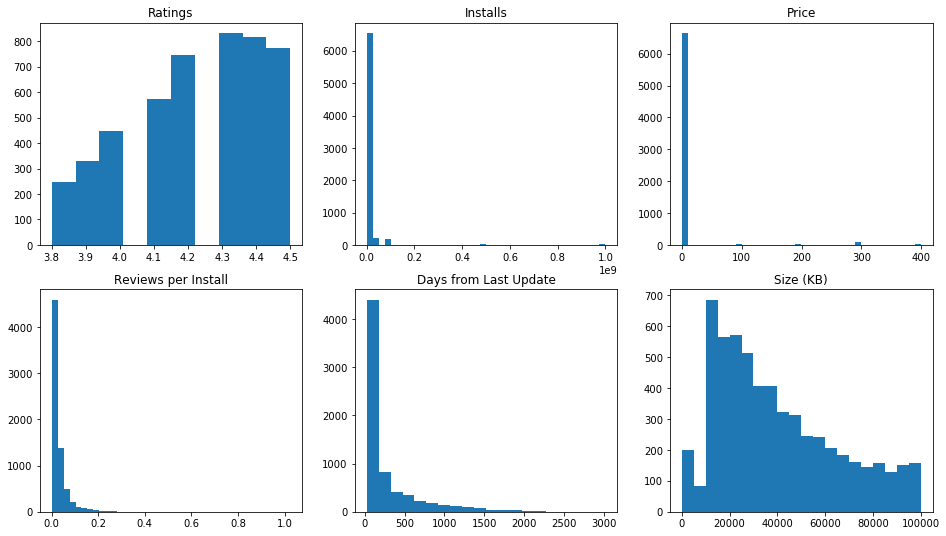

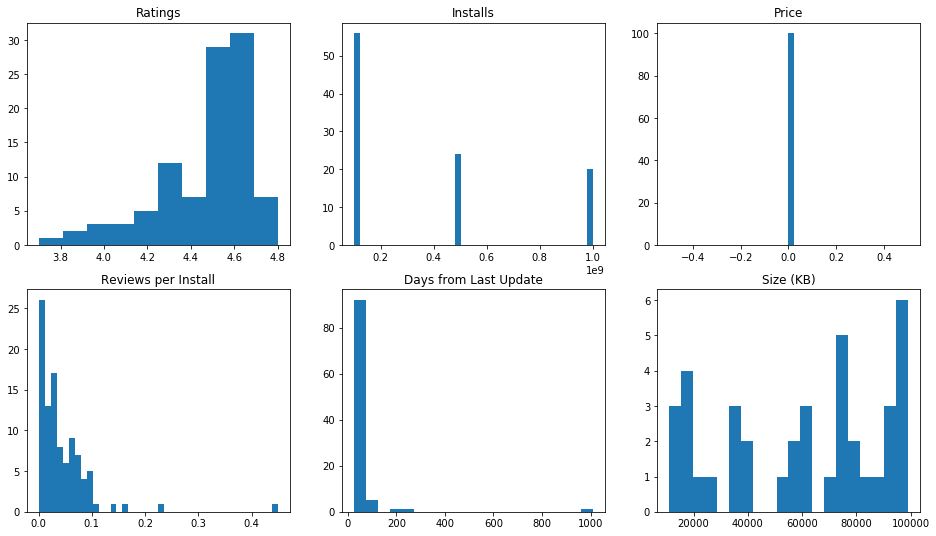

In [69]:
#comparisons
dist_plots(df_apps)
dist_plots(top_100)

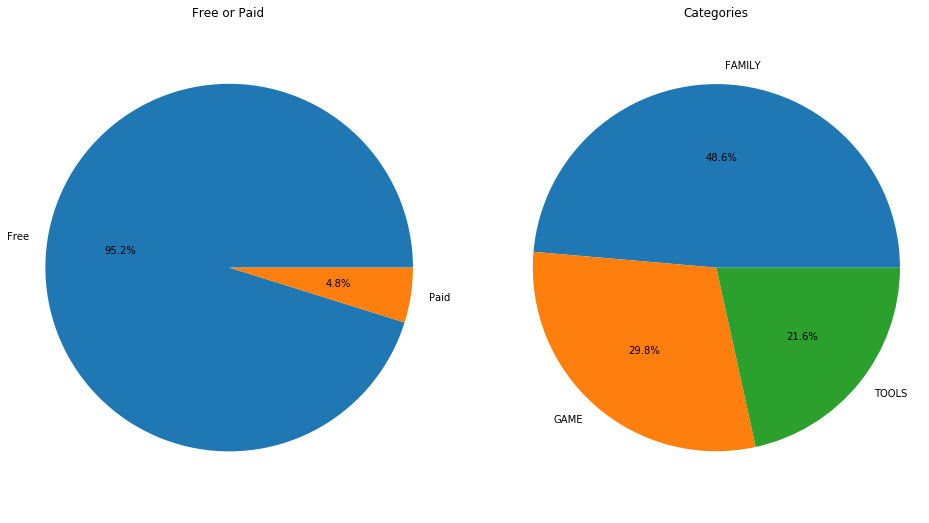

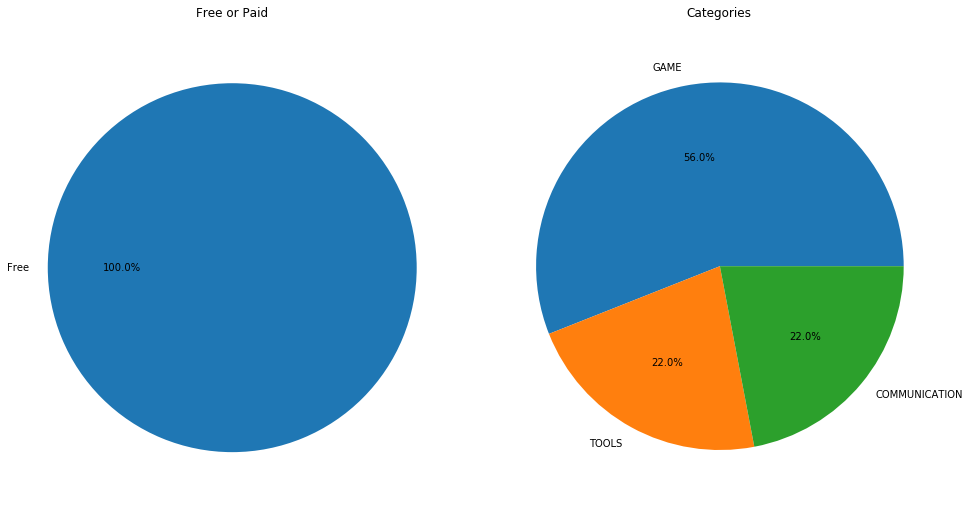

In [80]:
paid_cate(df_apps)
paid_cate(top_100)

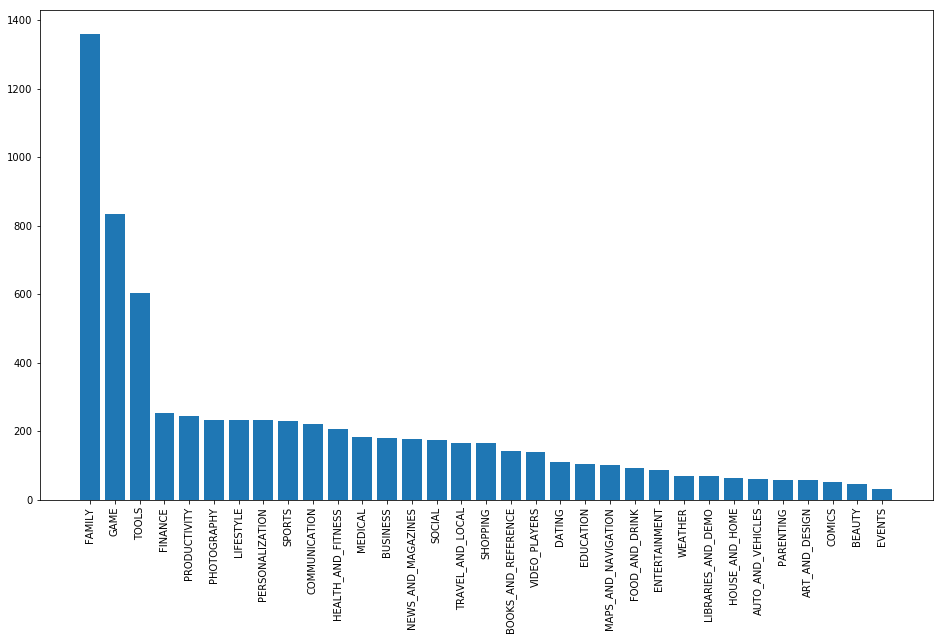

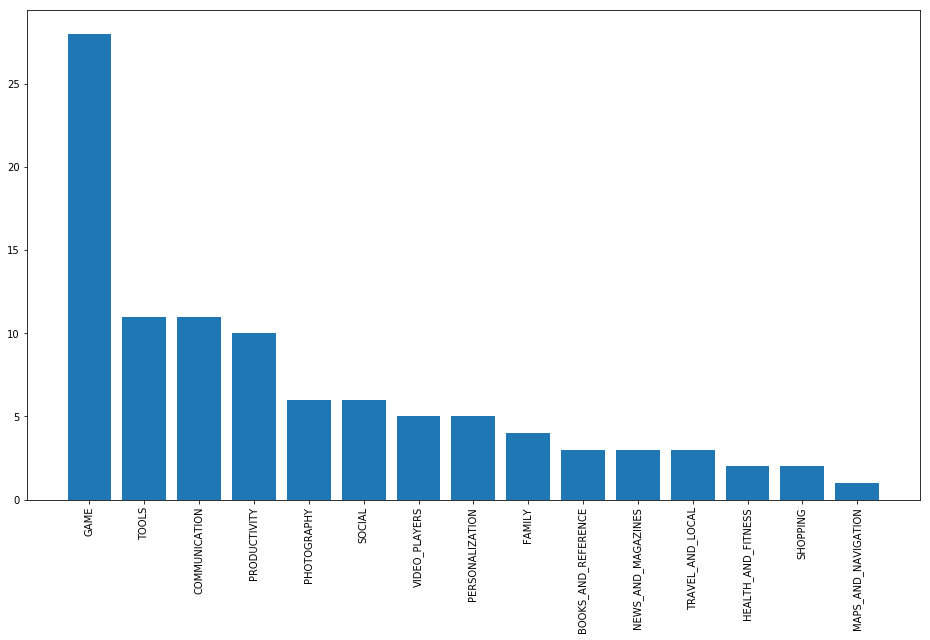

In [81]:
cate_breakdown(df_apps)
cate_breakdown(top_100)

In [13]:
df_apps.columns

Index(['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type',
       'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver',
       'Android Ver', 'installs_int', 'reviews_per_install', 'updated_delta',
       'rating_installs'],
      dtype='object')